# Scrape and analyze data analyst job requirements with Python
## Coursera Project Network
### By Cesar Perez
11/18/2023

## Introduction

For this project we'll help a recruitment agency and their candidates for the role of data analyst to find their ideal job based on technical skills. To archive this, we'll follow these steps:

1. Gather data from indeed.com (web-scraping), as for the current version of this notebook, we'll gather job id, title, description and URL.
2. Analyse job descriptions to find keywords related to technical skills.
3. Create a custome HTML communication for the candidate. As for the current version of this this notebook, we'll focus on the creation of a basic HTML template leaving the SMTP email sending algorithm out of scope for now.

Each step will be handled for a different Python function, let's prepare our environment and then define the functions, then we'll use them to create two customized recommendations for ficticional candidates.

In [36]:
import pandas as pd
import re
import os

from selenium import webdriver
from bs4 import BeautifulSoup

In [37]:
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_columns', None)

## Defining Functions.
### 1.Web-Scraping function.

If we want to help candidates find their ideal job we need to start by knowing what available offers are out there, so we'll look into one of the most popular sites nowadays, [indeed.com](https://www.indeed.com).

To gather relevant information from this site, we need our function to perform the following steps:
1. Send a GET request. Some of the variables used by this portal and that are relevent for our script are 'q' for quering, 'l' for location, 'fromage' controls the amount of days since a job was posted and 'start' controls the 'page' or indexing of jobs displayed (15 per page).
2. Scan the web response by indeed and locate Job-Ids, by digging a little bit on the indeed page structure using Chrome's dev console I was able to find inside a 'Script' tag an object, windows._initialData, having a nested json, jobKeysWithTwoPaneEligibility, lising the job-ids (shown bellow).

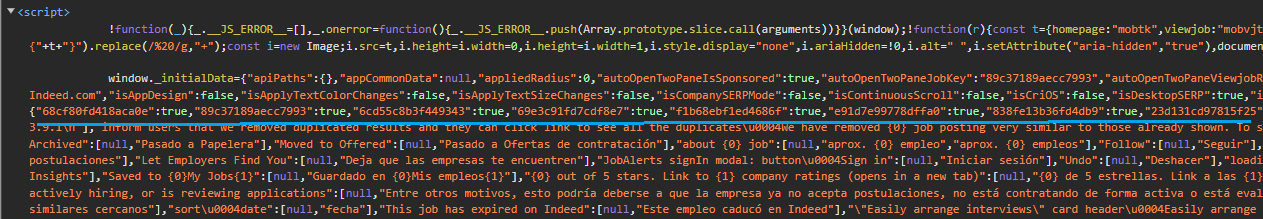

3. Having gathered the job-ids, send a second request to get the complete data about the postings. In oher words, the first query indeed to get job ids and then send a second query requesting specific information about each id.
4. Save the job URL, title and description into a dictionary using the id as key and the other attributes as a nested dictionary.
5. Return the dictionary for further use.

Let's define the function. Note that we are defining three of the function arguments with default values. Also, note that we are using a try - except block for the section handling the second request, meaning that if any error is encontered during the execution we'll just print the impacted id for our knowledge and move forward with the next one without interruption. Finally, note that for now we will only focus on indeed.com, meaning that the jobs are based on the United States.

In [38]:
def indeed_jobs(keyword, location = '', pages = 1, age = 30): 
    job_dict = dict()
    q_val = 'q='+'+'.join(keyword.split())
    l_val = '&l='+location if location != '' else ''
    fromage_val = '&fromage='+str(age)
    start_val = '&start=' 
    
    for page in range(1, pages+1):
        url = 'https://www.indeed.com/jobs?'+q_val+l_val+fromage_val+start_val+str((page*10)-10)
        dr = webdriver.Chrome()
        dr.get(url)
        bs = BeautifulSoup(dr.page_source,"html")
        
        for block in bs.find_all('script'):
            if '"jobKeysWithTwoPaneEligibility":' in str(block):
                job_ids= eval(re.search('"jobKeysWithTwoPaneEligibility":({[\w\"\"\,\:]+\})', str(block)).group(1).replace('true', 'True'))
                for job_id in job_ids.keys():
                    try:
                        job_detail_url = 'https://www.indeed.com/viewjob?jk='+job_id
                        dr.get(job_detail_url)
                        bs_jd = BeautifulSoup(dr.page_source,"html")
                        job_title = bs_jd.find('h1').find('span').text
                        job_description = bs_jd.find('div',attrs={'id':'jobDescriptionText'}).text.strip()
                        job_dict[job_id] = {'url': job_detail_url, 'title':job_title, 'description': job_description}
                    except:
                        print(f'Job: {job_id} failed - Ignoring')
                        continue
        dr.close()           
    return job_dict

### 2. Job Scaning function.

Having gathered raw data about a series of job postings, we want to come up with a practical way to summarize it in a way that we can recomend job postings to our candidates without having to read the whole post and decide which of our candidates could be a good fit, in other words, we want to make automated recomendations. To archieve this, we need a funtions that performs the following steps:

1. Receive raw data about the job postings (the output from our first function)
2. Search inside the job description a series of keywords that will help us identify the requirements the hiring team is looking for in the candidates. By doing this, we'll transform the job description from a long text into a series of boolean values that we will use as a criteria to match fitting candidates.
3. Concatenate each summarized job posting into a single dataframe.
4. Return the dataframe for further use.

To make bullet number two a viable approach to tackle our challenge, we need to be able to find common skills for a role and then identify the words (strings) used to descibe them, for example, "databases" is a skill, and words like "SQL", "PSQL", "sequel", "Postgres", etc., are directly related to this skill, so a job posting saying: "1+ years sxperience in SQL Server is preferred" will be categorized as requiring the databases skill for having a word associated wih the skill. So our funtion will require a second input, which is a dicionary having skils as keys and lists of associated words as values.

Let's define the function.

In [39]:
def scan_jobs(job_dict, skill_dict):
    job_df = pd.DataFrame({'Title':[], 'URL':[]})
    for skill in skill_dict.keys():
        job_df.insert(len(job_df.columns), skill, [], False)
        
    for job in job_dict.keys():
        title = job_dict[job]['title']
        url = job_dict[job]['url']
        job_df_row = {'Title':[title], 'URL':[url]}
        
        for skill in skill_dict.keys():
            job_df_row[skill] = False
            for keyword in skill_dict[skill]:
                if keyword.lower() in job_dict[job]['description'].lower(): 
                    job_df_row[skill] = True
                
        job_df = pd.concat([job_df, pd.DataFrame(job_df_row)], ignore_index = True)
        job_df.drop_duplicates(inplace=True)
    return job_df
        

### 3.Candidate communication function

Now its time to give value to our summarized dataframe by sharing with our candidates fitting job posibilities. We will archive this goal by defining a function that will:

1. Receive a candidate "profile", which is a dictionary having information about their current skills and use it to filter the summarized dataframe we created in our previous step so we get the best options for them. For now, the approach we'll take to provide recommendations will be simply by rating a job based on the sum of skills included from the candidate's profile, for example, if the candidate has the Python, SQL and Linux skills, a job having these 3 will rate 3 points, 2 points if only include Linux and Python and so on.
2. Transform the dataframe from our previous step into a new format, where we can see the percentage each skill occupy against the total amount of job postings in a way that the candidate knows what are the more demanded skills as per the last analysis.
3. Create a customized HTML communication.
4. Return the HTML.

Let's define the function

In [80]:
def html_communication(cadidate_name, candidate_profile, job_df, skill_dict, position):
    summary = pd.melt(job_df, value_vars=skill_dict.keys(), var_name = 'Skills', value_name='Count').groupby('Skills').sum().sort_values('Count', ascending=False).head(10)
    summary['%'] = round((summary['Count'] / result.shape[0]) * 100,2)
    
    candidate_recomendation = job_df
    candidate_skills = ['Title', 'URL']
    for skill in candidate_profile:
        if candidate_profile[skill] == True:
            candidate_skills.append(skill)
    candidate_recomendation = candidate_recomendation[candidate_skills]
    candidate_recomendation['total'] =  candidate_recomendation.iloc[:, 2:].sum(axis = 1)
    candidate_recomendation = candidate_recomendation.sort_values('total', ascending=False).head(5)
    
    Job_table = '<table><tr><th>Job Title</th><th>Link</th></tr>'
    for indx, row in candidate_recomendation[['Title', 'URL']].iterrows():
        title = row[0]
        url = row[1]
        table_row = f'<tr><td>{title}</td><td><a href="{str(url)}" target="_blank">Apply here!</a></td></tr>\n'
        Job_table += table_row
    Job_table += '</table>'
    
    top_skill_table = '<table><tr><th>Skill</th><th>Percentage</th></tr>'
    for indx, row in summary.iterrows():
        skill = indx
        percentage = row[1]
        table_row = f'<tr><td>{skill}</td><td>{percentage}%</td></tr>\n'
        top_skill_table += table_row
    top_skill_table += '</table>'
    
    style_tag = '''<style>
                div{
                    margin: auto;width: 90%;
                    padding: 10px;
                    font-family: Arial;
                }
                table {
                  font-family: arial, sans-serif;
                  border-collapse: collapse;
                  width: 100%;
                }
                
                td, th {
                  border: 1px solid #dddddd;
                  text-align: left;
                  padding: 8px;
                }
                
                tr:nth-child(even) {
                  background-color: #dddddd;
                }
                @media (min-width: 650px) {
                    div{
                        margin: auto;width: 50%;
                    }
                }
                </style>'''
    
    output_html = f'''<!doctype html>
            <html lang="en">
            <head>
                <title>Your Daily Job Recommendation</title>
                <meta name="viewport" content="width=device-width,initial-scale=1">
            </head>
            {style_tag}
            <body>
                <div>
                    <h1>Hello {cadidate_name}!</h1>
                    <h2>Are you ready to take the next step?</h2>
                    <p>We've found positions that fit your profile:</p>
                    {Job_table}
                    <h2>Do you know?</h2>
                    <p>As per our last analysis, these are the top 10 skill demanded for {position}:
                    {top_skill_table}
                </div>    
            </body>
            </html>'''
    return output_html

## Creating Job Recomendations

It's time to test our solution. First, we need to gather raw data from indeed, let's define the parameters we'll use to get data about data analyst jobs, let's focus on posts having up to 30 days, data from 150 indeed pages and for now we won't worry about the location.

In [41]:
position = 'Data Analyst'
pages = 150
age = 30

Let's run the first function saving the outcome on a variable called "job_dict".

In [42]:
job_dict = indeed_jobs(position, pages = pages, age = age)

Job: cee14f7c614444cc failed - Ignoring


Let's print the first job captured to show as an example.

In [43]:
job_dict[list(job_dict.keys())[0]]

{'url': 'https://www.indeed.com/viewjob?jk=f69950156bbdac29',
 'title': 'Data Analyst',
 'description': "At Alpine IQ, we're passionate about delivering innovative and effective software solutions to our clients. Our commitment to data-driven decision-making drives our success, and we're looking for a Data Analyst to join our team. This is an exciting opportunity for individuals looking to launch their career in the dynamic world of Software as a Service (SaaS) and make a significant impact in a fast-growing company.\n\n At Alpine IQ, the Data Analyst is a pivotal role, tasked with unlocking the power of data to drive insights for our Sales and Customer Success teams. With a keen eye for detail and a passion for numbers, you will be responsible for designing and maintaining dashboards that provide actionable insights into our sales processes, customer journeys, and success metrics. If you're driven by the challenge of converting complex data into compelling business narratives, we woul

Now let's create our dictionary for the skills we are considering relevant for the role of data analyst and that our candidates may or may not have. These dictionaries are the objects we can always revisit, this is because they can continually change as new technologies become popular or obselete. Also onsider that given that our function will work with subtrings a single keyword may match with multiple items on the job description, for example the substring "Statistic" will match with "Statistic", "Statistical", "Statisticts", etc., but for this same reason, we also need to be careful of keywords that can be taken out of context, for example words like "Excel", the Microsoft tool, to be considered as part of the word "excellent", which we expect to see on many postings like: "excellent communication skills are required...", for this reason, the definition bellow include commas, extra characters or spaces that allow us to limit those mistakes as much as possible, for example, we are using "MS Access" to avoid including the expression "to access". 

In [56]:
skill_dict = {'Databases': ['SQL', 'Transact-SQL', 'Sequel', 'Database', 'MySQL', 'Postgres', 'PostgreSQL', 'DB2','Oracle DB','OracleDB', 'MS Access', 'MSAccess', 'Microsoft Access'],
              'Non-Relational Databases':['MongoDB'],
              'Python': ['Python', 'Jupyter'], 
              'R (Programming Language)': [' R ', ', R,', ' R,',  ' R.',',R,'],
              'JavaScript': ['JavaScript'],
              'Java':['Java ', 'Java,', 'Java.'], 
              'PHP':['PHP'],
              'HTML':['HTML'],
              'Spreadsheets':['Excel ', 'Excel,','Excel.', 'spreadsheet', 'Google Sheets'], 
              'VBA':['VBA'], 
              'SAS':['SAS'],
              'SAP':[' SAP ', ', SAP', ',SAP,', ' SAP.'],
              'SPSS':['SPSS'],
              'Tableau':['Tableau'], 
              'Power BI':['Power BI', 'PowerBI'], 
              'Qlik': ['Qlik'],
              'Power Point':['Power Point', 'PowerPoint'],
              'ETL':['ETL', 'ELT'], 
              'Databricks':['Data bricks', 'Databricks'],
              'Snowflake':['Snowflake'],
              'Google Analytics': ['Google Analytics'],
              'Statisticts/Mathematics':['Statistic','Math'],
              'Linux':['Linux', 'Ubuntu', 'Debian', 'CentOS', 'Red Hat', 'RedHat','RHEL'],
              'Version Control Systems': [' Git ',' Git,', ',Git,',' Git.', 'GitHub', 'GitLab']}

let's run the second function saving the outcome into a variable called "result".

In [57]:
result = scan_jobs(job_dict, skill_dict)

C:\Users\perez\AppData\Local\Temp\ipykernel_15588\4000243932.py:17: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  job_df = pd.concat([job_df, pd.DataFrame(job_df_row)], ignore_index = True)


Let's print the first couple lines of the resulting output. As a refresher, the 1s and 0s indicate that at least one word related to the skill was identified regardless of how many there were, these values represent a true/false outcome and is not to be considered a count.

In [58]:
result.head()

,Title,URL,Databases,Non-Relational Databases,Python,R (Programming Language),JavaScript,Java,PHP,HTML,Spreadsheets,VBA,SAS,SAP,SPSS,Tableau,Power BI,Qlik,Power Point,ETL,Databricks,Snowflake,Google Analytics,Statisticts/Mathematics,Linux,Version Control Systems
0,Data Analyst,https://www.indeed.com/viewjob?jk=f69950156bbdac29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,Data Analyst,https://www.indeed.com/viewjob?jk=98d14a169483ded8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Data Analyst,https://www.indeed.com/viewjob?jk=2b79c482e030df68,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Data Analyst I,https://www.indeed.com/viewjob?jk=138bd3c14de00e5f,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Quantitative Analyst/Data Engineer,https://www.indeed.com/viewjob?jk=55e9ebb6557d2fc4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


As for the algorithm we do not expect to see any null values, let's confirm that

In [59]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29 entries, 0 to 28
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Title                     29 non-null     object 
 1   URL                       29 non-null     object 
 2   Databases                 29 non-null     float64
 3   Non-Relational Databases  29 non-null     float64
 4   Python                    29 non-null     float64
 5   R (Programming Language)  29 non-null     float64
 6   JavaScript                29 non-null     float64
 7   Java                      29 non-null     float64
 8   PHP                       29 non-null     float64
 9   HTML                      29 non-null     float64
 10  Spreadsheets              29 non-null     float64
 11  VBA                       29 non-null     float64
 12  SAS                       29 non-null     float64
 13  SAP                       29 non-null     float64
 14  SPSS        

In [60]:
result.to_csv('results.csv',  index=False)

Find the complete results table [here](results.csv)

For our knowledge, let's see the observed frecuencies per skill, remember that we are providing this information to our candidates as well (as a top 10). 

In [61]:
summary = pd.melt(result, value_vars=skill_dict.keys(), var_name = 'Skills', value_name='Count').groupby('Skills').sum().sort_values('Count', ascending=False)
summary['Percentage'] = round((summary['Count'] / result.shape[0]) * 100,2)
summary

,Count,Percentage
Skills,,
Databases,24.0,82.76
Statisticts/Mathematics,16.0,55.17
Tableau,12.0,41.38
R (Programming Language),11.0,37.93
Python,11.0,37.93
Spreadsheets,10.0,34.48
Power BI,6.0,20.69
SAS,5.0,17.24
ETL,4.0,13.79


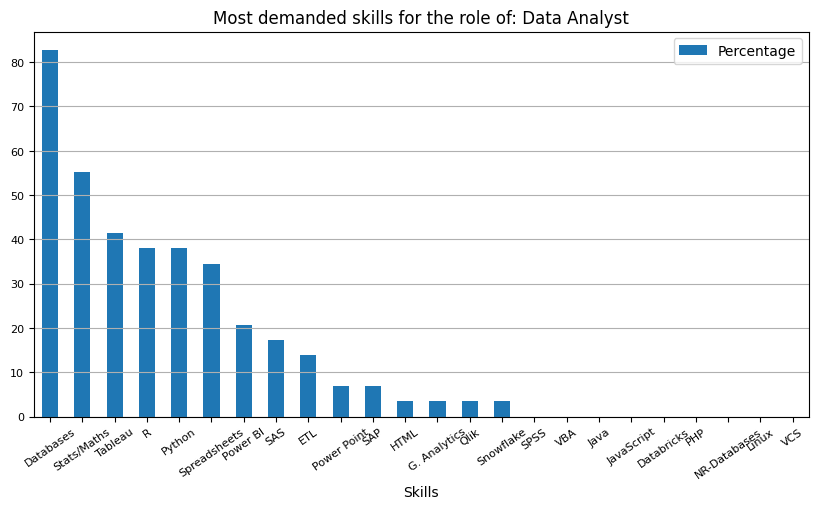

In [62]:
summary.rename(index={'R (Programming Language)': 'R', 'Statisticts/Mathematics':'Stats/Maths', 'Non-Relational Databases':'NR-Databases', 'Version Control Systems':'VCS', 'Google Analytics': 'G. Analytics'}).plot.bar(y='Percentage',title = f'Most demanded skills for the role of: {position}', rot=35, fontsize = 8, figsize = (10, 5)).grid(axis='y')

As new jobs are posted, it is expected that our analysis shows some variation each time it is executed, however, in almost all cases Databases and Statistics will come up on top, there is no question, every data professional should have a strong foundation working with tabular data and should feel confortable using this data to perform calculations using an SQL management system or Spreadsheets. Popular tools such as Tableau and Power BI are nice complement to our toolbox, finally being able to to automate tasks using a flexible and powerful programming language like Pyhon will help anyone to be more attractive for most companies.

Now, let's use our third and last function to transform our jobs into recommendations for the candidates. Given that we defined a set of skills as a dictionary, we should define a candidate's profile in the same way, replacing the list of associated words with a single True or False value, where True represents that the candidate has the specific skill or feels confortable with it. 

Let's create two fictional profiles:

Laura: she has experience working with Excel including VBA to automate some tasks, SAS, and she also has a strong knowledge of Tableau and Power BI to create dashboards and visualizations.

In [72]:
Laura_profile = {'Databases': False,
              'Non-Relational Databases':False,
              'Python':False, 
              'R (Programming Language)': False,
              'JavaScript':False,
              'Java':False, 
              'PHP':False,
              'HTML':False,
              'Spreadsheets':True, 
              'VBA':True, 
              'SAS':True,
              'SAP':False,
              'SPSS':False,
              'Tableau':True, 
              'Power BI':True, 
              'Qlik': False,
              'Power Point':False,
              'ETL':False, 
              'Databricks':False,
              'Snowflake':False,
              'Google Analytics':False,
              'Statisticts/Mathematics':False,
              'Linux':False,
              'Version Control Systems': False}

Robert: He has experience working with SQL, programming languages such as R and Python, GitHub as versioning control system, Linux distributions such as Ubuntu and he has also some experience with Tableau and Power BI.

In [73]:
Robert_profile = {'Databases': True,
              'Non-Relational Databases':False,
              'Python':True, 
              'R (Programming Language)': True,
              'JavaScript':False,
              'Java':False, 
              'PHP':False,
              'HTML':False,
              'Spreadsheets':True, 
              'VBA':False, 
              'SAS':False,
              'SAP':False,
              'SPSS':False,
              'Tableau':False, 
              'Power BI':True, 
              'Qlik': False,
              'Power Point':False,
              'ETL':False, 
              'Databricks':False,
              'Snowflake':False,
              'Google Analytics':False,
              'Statisticts/Mathematics':False,
              'Linux':True,
              'Version Control Systems': True}

Finally, let's create the custom HTML communication for our two candidates and save the output into a file.

In [81]:
Laura_email = html_communication('Laura', Laura_profile, result, skill_dict, position)
Robert_email = html_communication('Robert', Robert_profile, result, skill_dict, position)

C:\Users\perez\AppData\Local\Temp\ipykernel_15588\1074182653.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_recomendation['total'] =  candidate_recomendation.iloc[:, 2:].sum(axis = 1)
C:\Users\perez\AppData\Local\Temp\ipykernel_15588\1074182653.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_recomendation['total'] =  candidate_recomendation.iloc[:, 2:].sum(axis = 1)


Let's print Laura's communication as an example.

In [75]:
print(Laura_email)

<!doctype html>
            <html lang="en">
            <head>
                <title>Your Daily Job Recommendation</title>
                <meta name="viewport" content="width=device-width,initial-scale=1">
            </head>
            <style>
                div{
                    margin: auto;width: 90%;
                    padding: 10px;
                    font-family: Arial;
                }
                table {
                  font-family: arial, sans-serif;
                  border-collapse: collapse;
                  width: 100%;
                }
                
                td, th {
                  border: 1px solid #dddddd;
                  text-align: left;
                  padding: 8px;
                }
                
                tr:nth-child(even) {
                  background-color: #dddddd;
                }
                @media (min-width: 650px) {
                    div{
                        margin: auto;width: 50%;
                

Finally let's save the files, let's include link for those two bellow.

In [76]:
f = open("Laura.html", "w")
f.write(Laura_email)
f.close()

f = open("Robert.html", "w")
f.write(Robert_email)
f.close()

Find Laura's communication [here](Laura.html) and Robert's [here](Robert.html)

## What's next?

We had a lot of fun with this excercise, right? however there are clear limitations and areas where we can improve beyond this demo. here are just a few:

1. The word matching approach will never be 100% accurate. Complex algorithms can return better results but at the expense of being harder to maintain and update.
2. Capture more job attributes, like rating, salary, age, etc., this would help us do a better job selecting fitting positions for the candidates.
3. The skill definition we used here should also be revised, I proposed it based on my knowledge but would be better if more professionals can complement it too.
4. Include these steps inside an orchestrator for the automatic execution.
5. Enhance the html communication to include more aesthetics.
6. Use multiple threads to improve performance.

I would definetively consider the bullets above and more in a real implementation, but as of now, I feel happy with the results and patterns observed, which I think do reflect the reality and skills needed from people working as Data Analyst. 

Thanks for reading!!

find more about my job on my [public portfolio](https://rubenpv0989.github.io/MyPortfolio/index.html)